In [1]:
import numpy as np
import pandas as pd
randomSeed=42
np.random.seed(randomSeed)

In [2]:
data = pd.read_csv("iris.csv")
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
num_attributes= ["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]
num_pipeline= make_pipeline(
    StandardScaler()
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
])
processedData= preprocessing.fit_transform(data)
processedDf= pd.DataFrame(processedData, columns=preprocessing.get_feature_names_out())
processedDf.describe()

,num__SepalLengthCm,num__SepalWidthCm,num__PetalLengthCm,num__PetalWidthCm
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-4.736952e-16,-6.631732e-16,3.315866e-16,-2.842171e-16
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00
min,-1.870024e+00,-2.438987e+00,-1.568735e+00,-1.444450e+00
25%,-9.006812e-01,-5.877635e-01,-1.227541e+00,-1.181504e+00
50%,-5.250608e-02,-1.249576e-01,3.362659e-01,1.332259e-01
75%,6.745011e-01,5.692513e-01,7.627586e-01,7.905908e-01
max,2.492019e+00,3.114684e+00,1.786341e+00,1.710902e+00


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
y= data[["Species"]].values.flatten()
le = LabelEncoder()
labels_encoded = le.fit_transform(y)
X_train,X_test,y_train,y_test= train_test_split(processedData,labels_encoded,test_size=0.1,random_state=randomSeed,shuffle=True)
X_train.shape

(135, 4)

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
cv=5
softmax_reg = LogisticRegression(C=30, random_state=randomSeed)
def evaluateCV(model, X_train, y_train):
    return sum(cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy"))/cv
print(evaluateCV(softmax_reg,X_train,y_train))

0.962962962962963


In [41]:
import matplotlib.pyplot as plt
softmax_reg.fit(X_train,y_train)
probs = softmax_reg.predict_proba(X_test)


intercept= softmax_reg.intercept_
coef=softmax_reg.coef_.T
print(intercept)
print(coef)

[ 0.16026278  5.14825325 -5.30851603]
[[-2.16227165  1.58248836  0.57978329]
 [ 2.32318153 -0.21326395 -2.10991758]
 [-4.34972837 -1.91744635  6.26717472]
 [-4.13277339 -1.85188362  5.98465701]]


In [54]:
last2Intercept= intercept[-2:]
last2Intercept

array([ 5.14825325, -5.30851603])

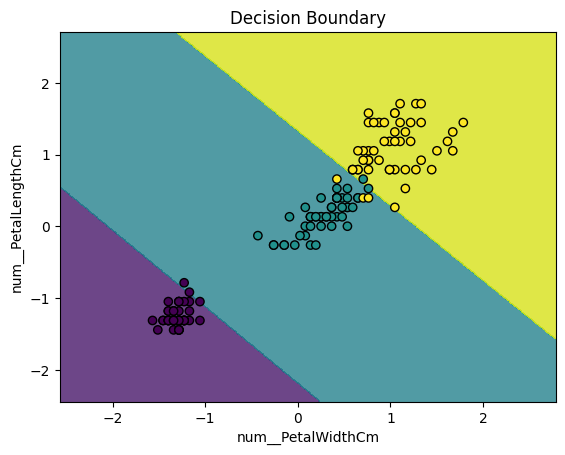

In [57]:
featureNames=processedDf.columns.tolist()
yFeatureIndex=2
xFeatureIndex=3

x_min, x_max = processedData[:, yFeatureIndex].min() - 1, processedData[:, yFeatureIndex].max() + 1
y_min, y_max = processedData[:, xFeatureIndex].min() - 1, processedData[:, xFeatureIndex].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

fixed_feature1= np.mean(processedData[:,0])
fixed_feature2= np.mean(processedData[:,1])

# Z = softmax_reg.predict(np.c_[fixed_feature1*np.ones(xx.ravel().shape),fixed_feature2*np.ones(xx.ravel().shape),xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# Apply softmax to obtain probabilities and predict the class with the highest probability
def softmax(scores):
    return np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
scores = np.dot(np.c_[xx.ravel(), yy.ravel()], coef[-2:]) + intercept
Z = np.argmax(softmax(scores), axis=1)
Z = Z.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(processedData[:, -2], processedData[:, -1], c=labels_encoded, edgecolors='k')
plt.xlabel(featureNames[xFeatureIndex])
plt.ylabel(featureNames[yFeatureIndex])
plt.title('Decision Boundary')
plt.show()